## You can possibly rerun this whole notebook but I have no idea if I reset the random seed before this successful run or not. So I didn't clear the outputs.

### Load files

I used Google Colab for this because it was a bit faster than my laptop.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip drive/MyDrive/train.zip

Archive:  drive/MyDrive/train.zip
  inflating: train.1.h5              
  inflating: train.2.h5              


---

### This part was provided by HTB

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import torch
from torch import nn
from torchvision import transforms
preprocess = transforms.Compose([
    transforms.Normalize(
        mean=np.array([0.1086, 0.0934, 0.0711]),
        std=np.array([0.1472, 0.123, 0.1032]))
])

import h5py

SEED = 1337
torch.manual_seed(SEED)
np.random.seed(SEED)
torch.use_deterministic_algorithms(True)

from model import StarChartModel, StarData

In [38]:
with h5py.File("train.1.h5", "r") as F:
    train_images1 = np.array(F["X"])
    train_labels1 = np.array(F["y"])
with h5py.File("train.2.h5", "r") as F:
    train_images2 = np.array(F["X"])
    train_labels2 = np.array(F["y"])
train_images = np.concatenate((train_images1, train_images2))
train_labels = np.concatenate((train_labels1, train_labels2))

In [39]:
batch_size = 32
train_set = StarData((train_images.transpose(0,3,1,2)/255), train_labels, transform=preprocess)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
    shuffle=True, num_workers=1, pin_memory=True)

In [40]:
flag = np.zeros((33,33))

I messed around with the dropout rates and the learning rate a lot. The 0.5 0.5 dropout was what ended up working out.

In [41]:
model = StarChartModel([0.5,0.5])
model.train()

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.0005)

---

### Let's train the network

Looks like input is 3x69x69 and output is 2 (mini batch size is 32). We'll go for 40 epochs and save the model after each epoch.

In [42]:
losses = []

In [43]:
n_epochs = 40
for epoch in range(n_epochs):
    counter = 0
    total_loss = 0
    for X_batch, y_batch, aa in train_loader:
        y_pred = model(X_batch)
        loss = loss_func(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        if counter % 30 == 3:
          print(f'{total_loss / counter:.2f} ', end='')
        counter += 1
    loss = total_loss / counter
    losses.append(loss)
    print(f'Epoch {epoch}: {loss}')
    torch.save(model, f'model{epoch:02}.pt')

0.93 0.71 0.70 0.70 0.69 0.69 0.68 0.68 0.68 0.68 0.68 Epoch 0: 0.6734472953521453
0.87 0.67 0.66 0.65 0.65 0.64 0.64 0.64 0.64 0.63 0.63 Epoch 1: 0.6204317920021825
0.71 0.61 0.57 0.57 0.56 0.56 0.55 0.54 0.54 0.54 0.53 Epoch 2: 0.530477842142632
0.69 0.54 0.52 0.51 0.51 0.50 0.49 0.49 0.49 0.49 0.48 Epoch 3: 0.4826522107954856
0.66 0.49 0.48 0.48 0.48 0.47 0.47 0.47 0.47 0.47 0.47 Epoch 4: 0.4683595749887976
0.60 0.46 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 Epoch 5: 0.45080138586304924
0.57 0.45 0.45 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 Epoch 6: 0.4352123092960667
0.56 0.45 0.44 0.44 0.44 0.44 0.43 0.43 0.43 0.43 0.43 Epoch 7: 0.4307665309390506
0.52 0.43 0.43 0.43 0.43 0.43 0.43 0.43 0.43 0.43 0.43 Epoch 8: 0.4307752503110124
0.59 0.42 0.42 0.42 0.42 0.42 0.42 0.42 0.42 0.42 0.42 Epoch 9: 0.41774195450562257
0.58 0.43 0.43 0.42 0.42 0.42 0.42 0.42 0.42 0.42 0.42 Epoch 10: 0.4186585026460367
0.50 0.43 0.43 0.43 0.43 0.43 0.43 0.42 0.42 0.42 0.42 Epoch 11: 0.41792935016634947


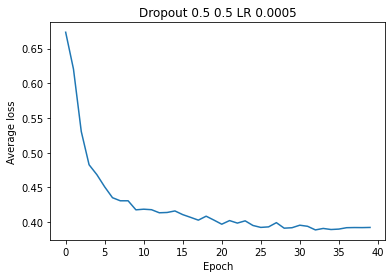

In [68]:
losses = [float(x) for x in losses]
plt.plot(losses)
plt.title('Dropout 0.5 0.5 LR 0.0005')
plt.xlabel('Epoch')
plt.ylabel('Average loss')
plt.show()

Looks pretty converged.

---

### Now let's see if the model gets us anything

Get all the test data

In [19]:
!unzip drive/MyDrive/test.h5.zip

Archive:  drive/MyDrive/test.h5.zip
  inflating: test.h5                 


In [3]:
test_images = None
with h5py.File("test.h5", "r") as f:
    test_images = np.array(f["X"])
test_images.shape

(33, 33, 2, 69, 69, 3)

This is kind of weird. The QR code we're trying to get is 33x33, so the first 2 dimensions make sense. The inputs to the model are supposed to be 3x69x69, so the last 3 dimensions make sense as well. The third dimension is kind of left over. We are going to end up with two 33x33 images if we put the test data through the model. This was something I messed around with quite a lot.

This function returns the model's output for the test data (two 33x33 arrays).

In [45]:
def get_outputs(model, raw=False):
    output1 = np.zeros((33, 33))
    output2 = np.zeros((33, 33))
    for i in range(33):
        for j in range(33):
            a = test_images[i][j][0]
            a = preprocess(torch.tensor(a.reshape((1, 69, 69, 3)).transpose(0, 3, 1, 2)/255).float())
            output = model(a)
            if raw:
              output1[i, j] = float(output[0][1])
            else:
              output1[i, j] = int(output.argmax())

            a = test_images[i][j][1]
            a = preprocess(torch.tensor(a.reshape((1, 69, 69, 3)).transpose(0, 3, 1, 2)/255).float())
            output = model(a)
            if raw:
              output2[i, j] = float(output[0][1])
            else:
              output2[i, j] = int(output.argmax())

    return output1, output2

---
Now that we have the model outputs, it's just a matter of figuring out how to put them together.

The following sections are some things I tried.

---
Let's try to fill out the mask.png a bunch of different ways.

In [22]:
from PIL import Image

In [46]:
# set_white should return true if that pixel should be set white
def get_qr(set_white, ouput1, output2, name='', show=True):
    mask = Image.open('mask.png').convert('L')
    for i in range(33):
        for j in range(33):
            if mask.getpixel((i, j)) != 0 and mask.getpixel((i, j)) != 255:
                if set_white(output1[i, j], output2[i, j]):
                    mask.putpixel((i, j), 255)
                else:
                    mask.putpixel((i, j), 0)
    if show:
        plt.imshow(mask, cmap='gray')
        plt.show()
        mask.save(name)
    else:
        return mask

In [29]:
from pyzbar.pyzbar import decode

Loop through every model we made and combine the two outputs in different ways. We're using a library to decode QR codes automatically, although I honestly don't really know how well it works.

Nothing came out of this anyway.

In [48]:
for i in range(n_epochs):
    model = torch.load(f'model{i:02}.pt')
    model.eval()
    output1, output2 = get_outputs(model)
    imgs = []
    imgs.append(get_qr(lambda o1, o2: o1 == 1, output1, output2, show=False))
    imgs.append(get_qr(lambda o1, o2: o2 == 1, output1, output2, show=False))
    imgs.append(get_qr(lambda o1, o2: o1 == 0, output1, output2, show=False))
    imgs.append(get_qr(lambda o1, o2: o2 == 0, output1, output2, show=False))
    imgs.append(get_qr(lambda o1, o2: True if (o1 == 1 and o2 == 1) else False, output1, output2, show=False))
    imgs.append(get_qr(lambda o1, o2: True if (o1 == 1 or o2 == 1) else False, output1, output2, show=False))
    imgs.append(get_qr(lambda o1, o2: True if (o1 == 0 and o2 == 0) else False, output1, output2, show=False))
    imgs.append(get_qr(lambda o1, o2: True if (o1 == 0 or o2 == 0) else False, output1, output2, show=False))
    for j, img in enumerate(imgs):
      if decode(img):
        print(f'{i} img{j}')

---
How does the difference between output1 and output2 change as we train? Are they supposed to converge into the same image eventually?

In [49]:
diff = []
for i in range(n_epochs):
    model = torch.load(f'model{i:02}.pt')
    model.eval()
    output1, output2 = get_outputs(model, raw=True)
    diff.append(np.absolute(output1 - output2).sum())

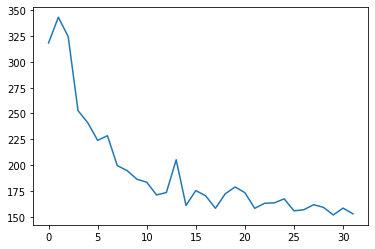

In [32]:
plt.plot(diff)
plt.show()

Looks like it. Maybe we'll take the average of the raw outputs of the two arrays and try to find a good weighted sum.

---
A lot of manual effort later:

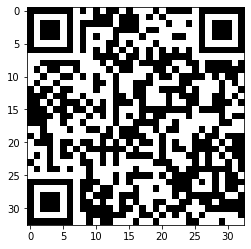

In [67]:
model = torch.load(f'model38.pt')
model.eval()
output1, output2 = get_outputs(model, raw=True)
plt.imshow((output1+output2)>1, cmap='gray')
plt.show()